# Google Research - Identify Contrails from Images
This notebook is an introductory exploration in the Kaggle competition of identifying airplane contrails from images. The competition link is [here](https://www.kaggle.com/competitions/google-research-identify-contrails-reduce-global-warming/data). The core of this competition is a **segmentation task**, where individuals pixels have to be coded on whether they contain a contrail or not.

The training data is extremely large (450 GB), so I'll be working with the validation data here, which is smaller at ~33 GB.

## Import Packages
First step as always is to import all the packages we'll need. We'll also save the path of the all the images.

In [3]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import json
import os

DATA_PATH = '../data/gr-contrails'

## Reading in the Metadata
The `validation_metadata.json` file contains a list of all the directories and samples in the folder.

In [7]:
with open(os.path.join(DATA_PATH, 'validation_metadata.json')) as f:
    validation_metadata = json.load(f)
validation_files = [entry['record_id'] for entry in validation_metadata]
print(f'There are {len(validation_files)} validation samples.')

There are 1856 validation samples.


From the competition site, we have the following for each sample folder:
> **band_{08-16}.npy**: array with size of `H x W x T`, where `T = n_times_before + n_times_after + 1`, representing the number of images in the sequence. There are `n_times_before` and `n_times_after` images before and after the labeled frame respectively. In our dataset all examples have `n_times_before=4` and `n_times_after=3`. Each band represents an infrared channel at different wavelengths and is converted to brightness temperatures based on the calibration parameters. The number in the filename corresponds to the GOES-16 ABI band number. Details of the ABI bands can be found [here](https://www.goes-r.gov/mission/ABI-bands-quick-info.html).
> **human_pixel_masks.npy**: array with size of H x W x 1 containing the binary ground truth. A pixel is regarded as contrail pixel in evaluation if it is labeled as contrail by more than half of the labelers.

According to the resource on the bands, the bands we have are 8 through 16, and these are all **infrared** bands, with increasing wavelength as the band number increases. Additionally, we also have 4 timesteps before, and 3 timesteps after the labeled frame. Thus, we have a combination of channeled and time series data, and from these we must produce a single masked image with a probability score on each pixel on whether it contains a contrail or not.

For this example, we'll look at the first entry in the metadata, **2243486080767052614**.

## Reading in a single sample

In [39]:
entry_id = '2243486080767052614'
entry_folder = os.path.join(DATA_PATH, entry_id)

## Visualizing a single contrail image
*Inspiration for this section came from [Kaggle's visualization notebook](https://www.kaggle.com/code/inversion/visualizing-contrails/notebook), that uses the same color scheme, but leaves out some information, which I've hopefully covered here.*

The contrail image samples are given in **bands**, which represent images that are taken at various wavelengths. In our dataset, all of these images are taken in the infrared (IR) range, at various wavelengths. As the band increases, the wavelength increases. Since these are not in the visual spectrum, in order to produce a proper image that can be human-viewed, we need to do some **false-coloring**, where we assign the RGB values to certain values at different bands. Value differences between the bands can be used as well.

Page 22 of [this paper](https://dspace.mit.edu/handle/1721.1/124179?show=full) by Kulik et al. suggests to use a variation of the ash color scheme. In this coloring, the contrails will appear dark blue against lighter backgrounds. The table is reproduced below.

| Color | Wavelength | Interpretation | Min [K] | Max [K] | Gamma |
| ----- | ---------- | -------------- | ------- | ------- | ----- |
| Red   | 12.4 $\mu$m - 11.2 $\mu$m | Optical thickness  | -4 | 2 | 1 |
| Green | 11.2 $\mu$m - 8.5 $\mu$m | Particle phase | -4 | 5 | 1 |
| Blue | 11.2 $\mu$m | Temperature | 243 | 303 | 1 |

Looking at the cheat sheet [at geos-r.gov](https://www.goes-r.gov/mission/ABI-bands-quick-info.html), we can see that 12.4 $\mu$m, 11.2 $\mu$m, and 8.5 $\mu$m corresponds most closely with bands 15, 14, and 11 respectively. Since the gamma enhancement factors are all 1, to produce the false color image, we do the following:

- For red, take the difference between bands 14 and 15, and scale as if the minimum and maximum are -4 and 2 respectively.
- For green, take the difference between bands 14 and 11, and scale as if the min and max are -4 and 5.
- For blue, scale band 11 assuming the min and max are 243 and 303.

Combining these three channels should produce an interpretable color image.


In [36]:
# Remember to take the 5th time step, as that's the one the ground truth pertains to.
band15 = np.load(os.path.join(entry_folder, 'band_15.npy'))[:, :, 5]
band14 = np.load(os.path.join(entry_folder, 'band_14.npy'))[:, :, 5]
band11 = np.load(os.path.join(entry_folder, 'band_11.npy'))[:, :, 5]
# Calculate R, G, and B channels
red = ((band15 - band14 + 4) / (2 + 4)).clip(0, 1)
green = ((band14 - band11 + 4) / (5 + 4)).clip(0, 1)
blue = ((band11 - 243) / (303 - 243)).clip(0, 1)
# Concatenate them to create a false color image
image = np.stack((red, green, blue), axis=2)

Now let's plot both the false color image and the ground truth side by side!

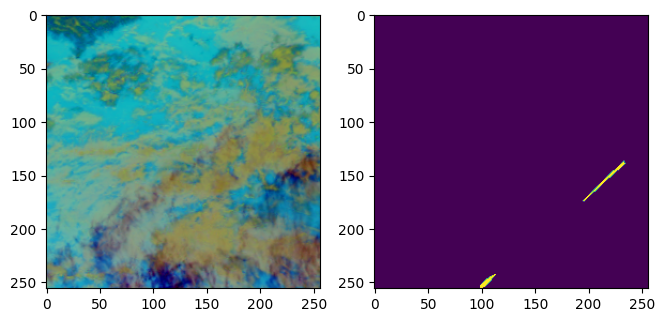

In [42]:
ground_truth = np.load(os.path.join(entry_folder, 'human_pixel_masks.npy'))

plt.figure(figsize=(12, 6))
ax = plt.subplot(1, 3, 1)
ax.imshow(image)

ax = plt.subplot(1, 3, 2)
ax.imshow(ground_truth)

plt.show()

This one is a bit hard to see, so we'll choose another image with more contrails. For simplicity, I'll include a function to do the plotting for us.

In [45]:
def plot_contrails(file_id):
    folder = os.path.join(DATA_PATH, file_id)
    # Remember to take the 5th time step, as that's the one the ground truth pertains to.
    band15 = np.load(os.path.join(folder, 'band_15.npy'))[:, :, 5]
    band14 = np.load(os.path.join(folder, 'band_14.npy'))[:, :, 5]
    band11 = np.load(os.path.join(folder, 'band_11.npy'))[:, :, 5]
    ground_truth = np.load(os.path.join(folder, 'human_pixel_masks.npy'))
    # Calculate R, G, and B channels
    red = ((band15 - band14 + 4) / (2 + 4)).clip(0, 1)
    green = ((band14 - band11 + 4) / (5 + 4)).clip(0, 1)
    blue = ((band11 - 243) / (303 - 243)).clip(0, 1)
    # Concatenate them to create a false color image
    image = np.stack((red, green, blue), axis=2)

    plt.figure(figsize=(12, 6))
    ax = plt.subplot(1, 3, 1)
    ax.imshow(image)

    ax = plt.subplot(1, 3, 2)
    ax.imshow(ground_truth)

    plt.show()

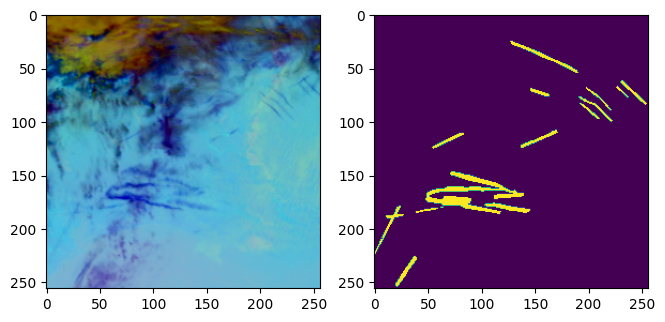

In [57]:
plot_contrails('4617259572479165215')

Hopefully you can see the dark blue wisps in the left image, that correspond with the yellow marks in the right. These are contrails, and these are the pixels that we eventually have to predict.